In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utils import sigmoid

In [2]:
lfc_color=np.array([55,126,184])/255
lhc_color=np.array([77,175,74])/255

SNR=-50 dB
SNR=-20 dB
SNR=-15 dB
SNR=-5 dB
SNR=0 dB
SNR=-50 dB
SNR=-20 dB
SNR=-15 dB
SNR=-5 dB
SNR=0 dB
SNR=-50 dB
SNR=-20 dB
SNR=-15 dB
SNR=-5 dB
SNR=0 dB


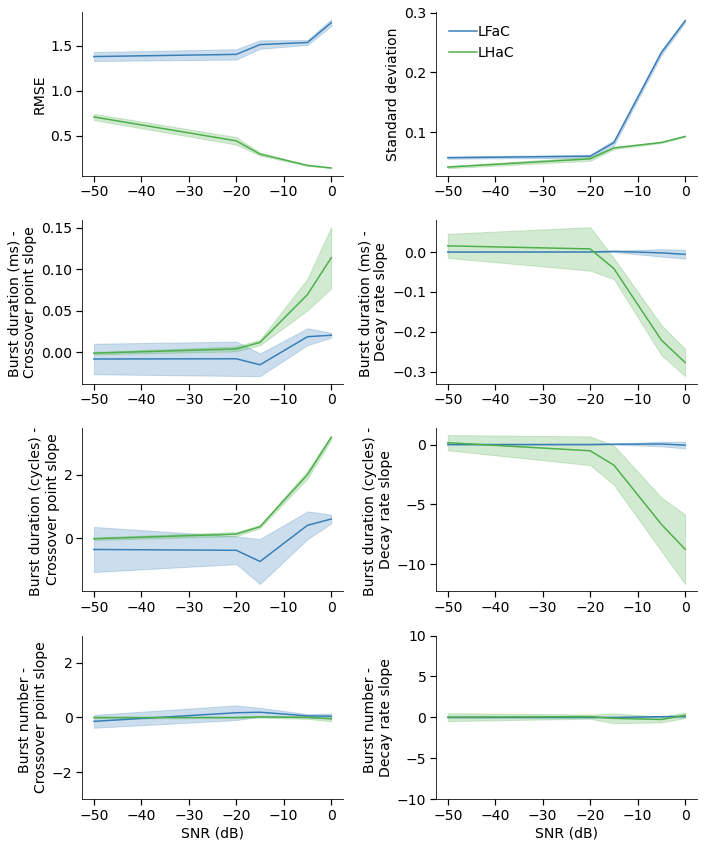

In [9]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(10,12))

f=np.load('../output/sims/oscillation/sim_results.npz')
lags=f['lags']
snrs=f['snrs']
freqs=f['freqs']
lcs_classic=f['lfc']
lcs_hilbert=f['lhc']
psds=f['psds']
osc_f=f['osc_f']

n_trials=100

classic_rmse = np.zeros((len(snrs),len(osc_f),n_trials))*np.nan
hilbert_rmse = np.zeros((len(snrs),len(osc_f),n_trials))*np.nan
classic_std = np.zeros((len(snrs),len(osc_f),n_trials))*np.nan
hilbert_std = np.zeros((len(snrs),len(osc_f),n_trials))*np.nan

for snr_idx in range(len(snrs)):
    for f_idx in range(len(osc_f)):
        for n in range(n_trials):
            lc_classic = lcs_classic[snr_idx,f_idx,n,:,:]
            lc_hilbert = lcs_hilbert[snr_idx,f_idx,n,:,:]

            f_psd_classic = np.nanmean(lc_classic,axis=1)
            classic_std[snr_idx,f_idx,n] = np.nanstd(f_psd_classic)
            f_psd_classic = f_psd_classic/np.nanmax(f_psd_classic)

            f_psd_hilbert = np.nanmean(lc_hilbert,axis=1)
            hilbert_std[snr_idx,f_idx,n] = np.nanstd(f_psd_hilbert)
            f_psd_hilbert = f_psd_hilbert/np.nanmax(f_psd_hilbert)

            f_psd = psds[-1,f_idx,n,:]
            f_psd = f_psd/np.max(f_psd)

            signal_power = np.nansum(f_psd)
            classic_rmse[snr_idx,f_idx,n] = np.sqrt(np.nansum((f_psd_classic-f_psd)**2)) / signal_power
            hilbert_rmse[snr_idx,f_idx,n] = np.sqrt(np.nansum((f_psd_hilbert-f_psd)**2)) / signal_power
            
# Average RMSE and Var over frequencies and trials
mean_classic_rmse = np.nanmean(classic_rmse, axis=(1, 2))
mean_hilbert_rmse = np.nanmean(hilbert_rmse, axis=(1, 2))
sd_classic_rmse = np.nanstd(np.nanmean(classic_rmse, axis=1),axis=-1)
sd_hilbert_rmse = np.nanstd(np.nanmean(hilbert_rmse, axis=1),axis=-1)

mean_classic_std = np.nanmean(classic_std, axis=(1, 2))
mean_hilbert_std = np.nanmean(hilbert_std, axis=(1, 2))
sd_classic_std = np.nanstd(np.nanmean(classic_std, axis=1),axis=-1)
sd_hilbert_std = np.nanstd(np.nanmean(hilbert_std, axis=1),axis=-1)

# Plotting
ax=plt.subplot(4,2,1)
ax.plot(snrs, mean_classic_rmse, label='LFaC',color=lfc_color)
ax.fill_between(snrs,mean_classic_rmse-sd_classic_rmse,mean_classic_rmse+sd_classic_rmse,alpha=.25,color=lfc_color)
ax.plot(snrs, mean_hilbert_rmse, label='LHaC',color=lhc_color)
ax.fill_between(snrs,mean_hilbert_rmse-sd_hilbert_rmse,mean_hilbert_rmse+sd_hilbert_rmse,alpha=.25,color=lhc_color)
ax.set_ylabel('RMSE')

ax=plt.subplot(4,2,2)
ax.plot(snrs, mean_classic_std, label='LFaC',color=lfc_color)
ax.fill_between(snrs,mean_classic_std-sd_classic_std,mean_classic_std+sd_classic_std,alpha=.25,color=lfc_color)
ax.plot(snrs, mean_hilbert_std, label='LHaC',color=lhc_color)
ax.fill_between(snrs,mean_hilbert_std-sd_hilbert_std,mean_hilbert_std+sd_hilbert_std,alpha=.25,color=lhc_color)
ax.set_ylabel('Standard deviation')
plt.legend()


f=np.load('../output/sims/burst_dur/sim_results.npz')
freqs=f['freqs']
snrs=f['snrs']

slopes={
    'lfc':{
        'x0': [],
        'k': []
    },
    'lhc':{
        'x0': [],
        'k': []
    }
}
for snr_idx, snr in enumerate(snrs):
    print(f'SNR={snr} dB')
    lcs_classic=f['lfc'][snr_idx,:,:,:,:]
    lcs_hilbert=f['lhc'][snr_idx,:,:,:,:]
    psds=f['psds'][snr_idx,:,:,:]
    brst_d=f['brst_d'][snr_idx,:,:]*1000
    brst_n=f['brst_n'][snr_idx,:,:]
    lags=f['lags']
    brst_f=f['brst_f']

    n_trials=lcs_classic.shape[1]

    snr_slopes={
        'lfc':{
            'x0': [],
            'k': []
        },
        'lhc':{
            'x0': [],
            'k': []
        }
    }
    for f_idx in range(len(brst_f)):
        freq=brst_f[f_idx]
        lc_f_idx=np.argmin(np.abs(freqs-freq))

        d_bursts=[]
        x0s_fourier=[]
        ks_fourier=[]        
        x0s_hilbert=[]
        ks_hilbert=[]
        for i in range(n_trials):
            lc_classic = lcs_classic[f_idx,i,:,:]
            lc_hilbert = lcs_hilbert[f_idx,i,:,:]
            d_bursts.append(brst_d[f_idx,i])

            b_lc_classic=lc_classic[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_classic, p0, method='lm',maxfev=100000)
            x0s_fourier.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_fourier.append(popt[1])
            
            b_lc_hilbert=lc_hilbert[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_hilbert, p0, method='lm',maxfev=100000)
            x0s_hilbert.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_hilbert.append(popt[1])
        d_bursts=np.array(d_bursts)
        
        x0s_fourier=np.array(x0s_fourier)
        ks_fourier=np.array(ks_fourier)
        x0s_hilbert=np.array(x0s_hilbert)
        ks_hilbert=np.array(ks_hilbert)

        d_bin_edges = np.linspace(np.percentile(d_bursts,5), np.percentile(d_bursts,95), 11)
        d_bin_indices = np.digitize(d_bursts, d_bin_edges)
        
        d_mean_x0s_fourier = np.array([np.mean(np.array(x0s_fourier)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        d_std_x0s_fourier = np.array([np.std(np.array(x0s_fourier)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])                
        d_mean_ks_fourier = np.array([np.mean(np.array(ks_fourier)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        d_std_ks_fourier = np.array([np.std(np.array(ks_fourier)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        x0_slope=(d_mean_x0s_fourier[-1]-d_mean_x0s_fourier[0])/(d_bin_edges[-2]-d_bin_edges[0])
        k_slope=(d_mean_ks_fourier[-1]-d_mean_ks_fourier[0])/(d_bin_edges[-2]-d_bin_edges[0])
        snr_slopes['lfc']['x0'].append(x0_slope)
        snr_slopes['lfc']['k'].append(k_slope)
        
        d_mean_x0s_hilbert = np.array([np.mean(np.array(x0s_hilbert)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        d_std_x0s_hilbert = np.array([np.std(np.array(x0s_hilbert)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])                
        d_mean_ks_hilbert = np.array([np.mean(np.array(ks_hilbert)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        d_std_ks_hilbert = np.array([np.std(np.array(ks_hilbert)[d_bin_indices == i]) for i in range(1, len(d_bin_edges))])
        x0_slope=(d_mean_x0s_hilbert[-1]-d_mean_x0s_hilbert[0])/(d_bin_edges[-2]-d_bin_edges[0])
        k_slope=(d_mean_ks_hilbert[-1]-d_mean_ks_hilbert[0])/(d_bin_edges[-2]-d_bin_edges[0])
        snr_slopes['lhc']['x0'].append(x0_slope)
        snr_slopes['lhc']['k'].append(k_slope)
    for method in ['lfc','lhc']:
        for param in ['x0','k']:
            slopes[method][param].append(snr_slopes[method][param])

for method in ['lfc','lhc']:
    for param in ['x0','k']:
        slopes[method][param]=np.array(slopes[method][param])
        
ax=plt.subplot(4,2,3)
m_x0=np.mean(slopes['lfc']['x0'],axis=-1)
sd_x0=np.std(slopes['lfc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lfc_color)

m_x0=np.mean(slopes['lhc']['x0'],axis=-1)
sd_x0=np.std(slopes['lhc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lhc_color)
ax.set_ylabel('Burst duration (ms) - \nCrossover point slope')

ax=plt.subplot(4,2,4)
m_k=np.mean(slopes['lfc']['k'],axis=-1)
sd_k=np.std(slopes['lfc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lfc_color)

m_k=np.mean(slopes['lhc']['k'],axis=-1)
sd_k=np.std(slopes['lhc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lhc_color)
ax.set_ylabel('Burst duration (ms) - \nDecay rate slope')



f=np.load('../output/sims/burst_dur/sim_results.npz')
freqs=f['freqs']
snrs=f['snrs']

slopes={
    'lfc':{
        'x0': [],
        'k': []
    },
    'lhc':{
        'x0': [],
        'k': []
    }
}
for snr_idx, snr in enumerate(snrs):
    print(f'SNR={snr} dB')
    lcs_classic=f['lfc'][snr_idx,:,:,:,:]
    lcs_hilbert=f['lhc'][snr_idx,:,:,:,:]
    psds=f['psds'][snr_idx,:,:,:]
    brst_d_c=f['brst_d_c'][snr_idx,:,:]
    brst_n=f['brst_n'][snr_idx,:,:]
    lags=f['lags']
    brst_f=f['brst_f']

    n_trials=lcs_classic.shape[1]

    snr_slopes={
        'lfc':{
            'x0': [],
            'k': []
        },
        'lhc':{
            'x0': [],
            'k': []
        }
    }
    for f_idx in range(len(brst_f)):
        freq=brst_f[f_idx]
        lc_f_idx=np.argmin(np.abs(freqs-freq))

        d_c_bursts=[]
        x0s_fourier=[]
        ks_fourier=[]        
        x0s_hilbert=[]
        ks_hilbert=[]
        for i in range(n_trials):
            lc_classic = lcs_classic[f_idx,i,:,:]
            lc_hilbert = lcs_hilbert[f_idx,i,:,:]
            d_c_bursts.append(brst_d_c[f_idx,i])

            b_lc_classic=lc_classic[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_classic, p0, method='lm',maxfev=100000)
            x0s_fourier.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_fourier.append(popt[1])
            
            b_lc_hilbert=lc_hilbert[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_hilbert, p0, method='lm',maxfev=100000)
            x0s_hilbert.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_hilbert.append(popt[1])
        d_c_bursts=np.array(d_c_bursts)

        x0s_fourier=np.array(x0s_fourier)
        ks_fourier=np.array(ks_fourier)
        x0s_hilbert=np.array(x0s_hilbert)
        ks_hilbert=np.array(ks_hilbert)

        d_c_bin_edges = np.linspace(np.min(d_c_bursts), np.max(d_c_bursts), 11)
        d_c_bin_indices = np.digitize(d_c_bursts, d_c_bin_edges)
        
        d_c_mean_x0s_fourier = np.array([np.nanmean(np.array(x0s_fourier)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        d_c_std_x0s_fourier = np.array([np.nanstd(np.array(x0s_fourier)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])        
        d_c_mean_ks_fourier = np.array([np.nanmean(np.array(ks_fourier)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        d_c_std_ks_fourier = np.array([np.nanstd(np.array(ks_fourier)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        x0_slope=(d_c_mean_x0s_fourier[-1]-d_c_mean_x0s_fourier[0])/(d_c_bin_edges[-2]-d_c_bin_edges[0])
        k_slope=(d_c_mean_ks_fourier[-1]-d_c_mean_ks_fourier[0])/(d_c_bin_edges[-2]-d_c_bin_edges[0])
        snr_slopes['lfc']['x0'].append(x0_slope)
        snr_slopes['lfc']['k'].append(k_slope)

        d_c_mean_x0s_hilbert = np.array([np.nanmean(np.array(x0s_hilbert)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        d_c_std_x0s_hilbert = np.array([np.nanstd(np.array(x0s_hilbert)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])        
        d_c_mean_ks_hilbert = np.array([np.nanmean(np.array(ks_hilbert)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        d_c_std_ks_hilbert = np.array([np.nanstd(np.array(ks_hilbert)[d_c_bin_indices == i]) for i in range(1, len(d_c_bin_edges))])
        x0_slope=(d_c_mean_x0s_hilbert[-1]-d_c_mean_x0s_hilbert[0])/(d_c_bin_edges[-2]-d_c_bin_edges[0])
        k_slope=(d_c_mean_ks_hilbert[-1]-d_c_mean_ks_hilbert[0])/(d_c_bin_edges[-2]-d_c_bin_edges[0])
        snr_slopes['lhc']['x0'].append(x0_slope)
        snr_slopes['lhc']['k'].append(k_slope)
        
    for method in ['lfc','lhc']:
        for param in ['x0','k']:
            slopes[method][param].append(snr_slopes[method][param])

for method in ['lfc','lhc']:
    for param in ['x0','k']:
        slopes[method][param]=np.array(slopes[method][param])

ax=plt.subplot(4,2,5)
m_x0=np.mean(slopes['lfc']['x0'],axis=-1)
sd_x0=np.std(slopes['lfc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lfc_color)

m_x0=np.mean(slopes['lhc']['x0'],axis=-1)
sd_x0=np.std(slopes['lhc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lhc_color)
ax.set_ylabel('Burst duration (cycles) - \nCrossover point slope')

ax=plt.subplot(4,2,6)
m_k=np.mean(slopes['lfc']['k'],axis=-1)
sd_k=np.std(slopes['lfc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lfc_color)

m_k=np.mean(slopes['lhc']['k'],axis=-1)
sd_k=np.std(slopes['lhc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lhc_color)
ax.set_ylabel('Burst duration (cycles) - \nDecay rate slope')



f=np.load('../output/sims/burst_num/sim_results.npz')
freqs=f['freqs']
snrs=f['snrs']

slopes={
    'lfc':{
        'x0': [],
        'k': []
    },
    'lhc':{
        'x0': [],
        'k': []
    }
}
for snr_idx, snr in enumerate(snrs):
    print(f'SNR={snr} dB')

    lcs_classic=f['lfc'][snr_idx,:,:,:,:]
    lcs_hilbert=f['lhc'][snr_idx,:,:,:,:]
    psds=f['psds'][snr_idx,:,:,:]
    brst_n=f['brst_n'][snr_idx,:,:]
    lags=f['lags']
    brst_f=f['brst_f']

    n_trials=lcs_classic.shape[1]

    snr_slopes={
        'lfc':{
            'x0': [],
            'k': []
        },
        'lhc':{
            'x0': [],
            'k': []
        }
    }

    for f_idx in range(len(brst_f)):
        freq=brst_f[f_idx]
        lc_f_idx=np.argmin(np.abs(freqs-freq))

        n_bursts=[]
        x0s_fourier=[]
        ks_fourier=[]        
        x0s_hilbert=[]
        ks_hilbert=[]
        for i in range(n_trials):
            lc_classic = lcs_classic[f_idx,i,:,:]
            lc_hilbert = lcs_hilbert[f_idx,i,:,:]
            n_bursts.append(brst_n[f_idx,i])

            b_lc_classic=lc_classic[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_classic, p0, method='lm',maxfev=100000)
            x0s_fourier.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_fourier.append(popt[1])
            
            b_lc_hilbert=lc_hilbert[lc_f_idx,:]
            p0 = [np.median(lags),3]
            popt, pcov = curve_fit(sigmoid, lags, b_lc_hilbert, p0, method='lm',maxfev=100000)
            x0s_hilbert.append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
            ks_hilbert.append(popt[1])
        n_bursts=np.array(n_bursts)

        x0s_fourier=np.array(x0s_fourier)
        ks_fourier=np.array(ks_fourier)
        x0s_hilbert=np.array(x0s_hilbert)
        ks_hilbert=np.array(ks_hilbert)

        n_bin_edges = np.arange(1,7)
        n_bin_indices = np.digitize(n_bursts, n_bin_edges)
        
        n_mean_x0s_fourier = np.array([np.mean(np.array(x0s_fourier)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        n_std_x0s_fourier = np.array([np.std(np.array(x0s_fourier)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])        
        n_mean_ks_fourier = np.array([np.mean(np.array(ks_fourier)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        n_std_ks_fourier = np.array([np.std(np.array(ks_fourier)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        x0_slope=(n_mean_x0s_fourier[-1]-n_mean_x0s_fourier[0])/(n_bin_edges[-2]-n_bin_edges[0])
        k_slope=(n_mean_ks_fourier[-1]-n_mean_ks_fourier[0])/(n_bin_edges[-2]-n_bin_edges[0])
        snr_slopes['lfc']['x0'].append(x0_slope)
        snr_slopes['lfc']['k'].append(k_slope)
        
        n_mean_x0s_hilbert = np.array([np.mean(np.array(x0s_hilbert)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        n_std_x0s_hilbert = np.array([np.std(np.array(x0s_hilbert)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])        
        n_mean_ks_hilbert = np.array([np.mean(np.array(ks_hilbert)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        n_std_ks_hilbert = np.array([np.std(np.array(ks_hilbert)[n_bin_indices == i]) for i in range(1, len(n_bin_edges))])
        x0_slope=(n_mean_x0s_hilbert[-1]-n_mean_x0s_hilbert[0])/(n_bin_edges[-2]-n_bin_edges[0])
        k_slope=(n_mean_ks_hilbert[-1]-n_mean_ks_hilbert[0])/(n_bin_edges[-2]-n_bin_edges[0])
        snr_slopes['lhc']['x0'].append(x0_slope)
        snr_slopes['lhc']['k'].append(k_slope)
   
    for method in ['lfc','lhc']:
        for param in ['x0','k']:
            slopes[method][param].append(snr_slopes[method][param])

for method in ['lfc','lhc']:
    for param in ['x0','k']:
        slopes[method][param]=np.array(slopes[method][param])

        
ax=plt.subplot(4,2,7)
m_x0=np.mean(slopes['lfc']['x0'],axis=-1)
sd_x0=np.std(slopes['lfc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lfc_color)

m_x0=np.mean(slopes['lhc']['x0'],axis=-1)
sd_x0=np.std(slopes['lhc']['x0'],axis=-1)
ax.plot(snrs,m_x0,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_x0-sd_x0,m_x0+sd_x0,alpha=.25,color=lhc_color)
ax.set_ylim([-3,3])

ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Burst number - \nCrossover point slope')

ax=plt.subplot(4,2,8)
m_k=np.mean(slopes['lfc']['k'],axis=-1)
sd_k=np.std(slopes['lfc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LFaC',color=lfc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lfc_color)

m_k=np.mean(slopes['lhc']['k'],axis=-1)
sd_k=np.std(slopes['lhc']['k'],axis=-1)
ax.plot(snrs,m_k,label='LHaC',color=lhc_color)
ax.fill_between(snrs,m_k-sd_k,m_k+sd_k,alpha=.25,color=lhc_color)
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Burst number - \nDecay rate slope')
ax.set_ylim([-10,10])


plt.tight_layout()

fig.savefig('../output/figures/figure_5.pdf')